In [ ]:
pip install -r Requirements.txt

In [ ]:
import pandas as pd
import xmltodict

import pprint
import json

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import nltk
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
import numpy as np
import joblib

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
with open('semeval14/Restaurants_Test_Gold.xml') as fd:
    doc = xmltodict.parse(fd.read())

In [ ]:
doc['sentences']['sentence'][0]

{'@id': '32897564#894393#2',
 'text': 'The bread is top notch as well.',
 'aspectTerms': {'aspectTerm': {'@term': 'bread',
   '@polarity': 'positive',
   '@from': '4',
   '@to': '9'}},
 'aspectCategories': {'aspectCategory': {'@category': 'food',
   '@polarity': 'positive'}}}

In [ ]:
doc['sentences']['sentence'][4]

{'@id': '32894246#870052#0',
 'text': 'Certainly not the best sushi in New York, however, it is always fresh, and the place is very clean, sterile.',
 'aspectTerms': {'aspectTerm': [{'@term': 'sushi',
    '@polarity': 'conflict',
    '@from': '23',
    '@to': '28'},
   {'@term': 'place', '@polarity': 'positive', '@from': '79', '@to': '84'}]},
 'aspectCategories': {'aspectCategory': [{'@category': 'food',
    '@polarity': 'conflict'},
   {'@category': 'ambience', '@polarity': 'positive'}]}}

In [ ]:
def convert_to_df(input_data):
    # Takes in input data is a list of dictionary
    # Returns pandas dataframe with text, aspect categories as list and polarity as list
    # Changes anecdotes/miscellaneous to other (easy to read and shorter with same meaning)
    # Create a combined label column as well

    data_rows = [] # we will use this later to create df
    for data in input_data:
        new_row = {}

        # Add text from the original dictionary
        new_row['text'] = data['text']


        # Extracting categories and polarity as list

        # If multiple categories are present
        # {'aspectCategories': {'aspectCategory': [{'@category': 'food', '@polarity': 'conflict'},{'@category': 'ambience', '@polarity': 'positive'}]}}

        # If single category is present
        # {'aspectCategories': {'aspectCategory': {'@category': 'food', '@polarity': 'positive'}}}

        # If no category is present
        # {}


        # It can eithrer not exist, be a single dict or a list of dict

        categories_dict = data.get('aspectCategories', {})
        # get the data if exists else a empty dict

        categories = categories_dict.get('aspectCategory', [])
        # get the data (might be a single dict or list of dict) or empty list

        if not isinstance(categories, list):
            categories =[categories] # convert to list of dict if a single dict

        new_row['category'] = []
        new_row['polarity'] = []
        new_row['joint'] = []

        for cat in categories:
            if cat['@category'] == 'anecdotes/miscellaneous':
                category = 'other'
            else:
                category = cat['@category']

            polarity = cat['@polarity']
            joint = category + '#' + polarity


            new_row['polarity'].append(polarity)
            new_row['category'].append(category)
            new_row['joint'].append(joint)

        data_rows.append(new_row)

    df = pd.DataFrame(data_rows, columns=['text', 'category', 'polarity', 'joint'])

    return df


In [ ]:
convert_to_df(doc['sentences']['sentence']).head()

,text,category,polarity,joint
0,The bread is top notch as well.,[food],[positive],[food#positive]
1,I have to say they have one of the fastest del...,[service],[positive],[service#positive]
2,Food is always fresh and hot- ready to eat!,[food],[positive],[food#positive]
3,Did I mention that the coffee is OUTSTANDING?,[food],[positive],[food#positive]
4,"Certainly not the best sushi in New York, howe...","[food, ambience]","[conflict, positive]","[food#conflict, ambience#positive]"


## Creating a single function to create df from xml file

In [ ]:

def convert_file_to_df(filepath):
    with open(filepath) as fd:
        doc = xmltodict.parse(fd.read())

    df = convert_to_df(doc['sentences']['sentence'])

    return df

In [ ]:
train_df = convert_file_to_df('semeval14/Restaurants_Train_v2.xml')
test_df = convert_file_to_df('semeval14/Restaurants_Test_Gold.xml')

In [ ]:
print("Size of Train set : ", train_df.shape)
print("Size of Test set : ", test_df.shape)

Size of Train set :  (3041, 4)
Size of Test set :  (800, 4)


In [ ]:
train_df.head()

,text,category,polarity,joint
0,But the staff was so horrible to us.,[service],[negative],[service#negative]
1,"To be completely fair, the only redeeming fact...","[food, other]","[positive, negative]","[food#positive, other#negative]"
2,"The food is uniformly exceptional, with a very...",[food],[positive],[food#positive]
3,Where Gabriela personaly greets you and recomm...,[service],[positive],[service#positive]
4,"For those that go once and don't enjoy it, all...",[other],[positive],[other#positive]


In [ ]:
test_df.head()

,text,category,polarity,joint
0,The bread is top notch as well.,[food],[positive],[food#positive]
1,I have to say they have one of the fastest del...,[service],[positive],[service#positive]
2,Food is always fresh and hot- ready to eat!,[food],[positive],[food#positive]
3,Did I mention that the coffee is OUTSTANDING?,[food],[positive],[food#positive]
4,"Certainly not the best sushi in New York, howe...","[food, ambience]","[conflict, positive]","[food#conflict, ambience#positive]"


## Exploring data

In [ ]:
category_counts = train_df['category'].explode().value_counts().reset_index()
category_counts.columns = ["category", "count"]

polarity_counts = train_df['polarity'].explode().value_counts().reset_index()
polarity_counts.columns = ["polarity", "count"]

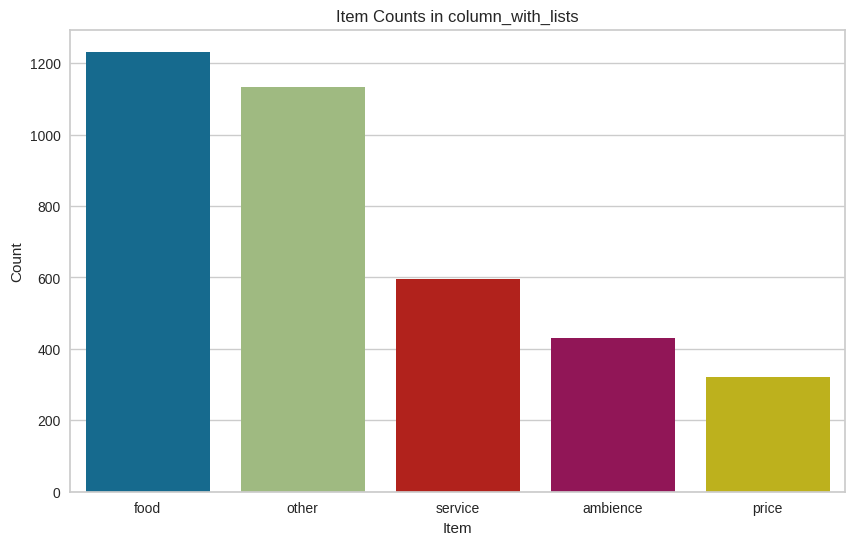

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='count', data=category_counts)
plt.title('Item Counts in column_with_lists')
plt.xlabel('Item')
plt.ylabel('Count')
plt.show()

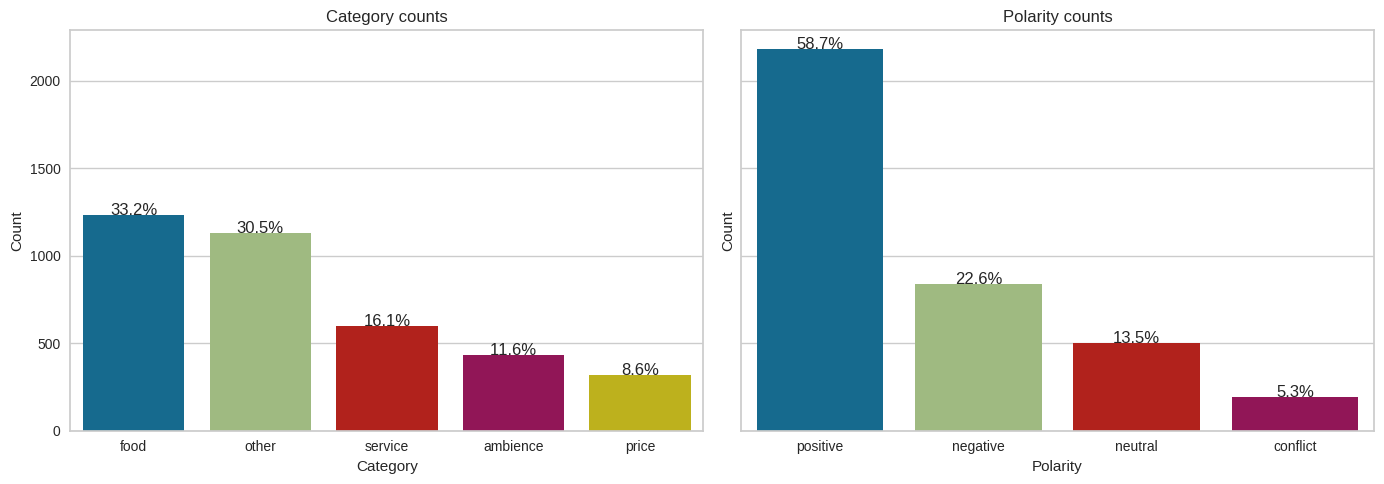

In [ ]:
# Plot side-by-side using seaborn
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot the first bar chart
sns.barplot(x='category', y='count', data=category_counts, ax=axes[0])
axes[0].set_title('Category counts')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')

# Add percentage annotations for the first bar chart
total_items_1 = category_counts['count'].sum()
for p in axes[0].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_items_1)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[0].annotate(percentage, (x, y), ha='center')

# Plot the second bar chart
sns.barplot(x='polarity', y='count', data=polarity_counts, ax=axes[1])
axes[1].set_title('Polarity counts')
axes[1].set_xlabel('Polarity')
axes[1].set_ylabel('Count')

# Add percentage annotations for the second bar chart
total_items_2 = polarity_counts['count'].sum()
for p in axes[1].patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_items_2)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[1].annotate(percentage, (x, y), ha='center')

plt.tight_layout()
plt.savefig('bargraph.pdf', dpi=300)
plt.show()

## Data Preprocessing

### Text cleaning

In [ ]:
# lower case text
# replace new line with space
# remove stopwords
# keep only alphabetic tokens


STOPWORDS_EN = nltk.corpus.stopwords.words('english')
def clean_text(text):
    text = text.replace("\n", " ")

    tokens = nltk.tokenize.word_tokenize(text.lower()) # tokenize the text
    tokens = [tok for tok in tokens if tok.isalpha()] # only keep alphabet tokens
    tokens = [tok for tok in tokens if tok not in STOPWORDS_EN] # remove stopwords
    cleanText = " ".join(tokens)
    return cleanText

In [ ]:
train_df["text"] = train_df["text"].apply(clean_text)
test_df["text"] = test_df["text"].apply(clean_text)

### Remove conflict

In [ ]:
# Filter out rows with 'conflict' polarity
# If one of the category has conflict polarity, we remove the entire review

train_df = train_df[~train_df['polarity'].apply(lambda x: 'conflict' in x)]
test_df = test_df[~test_df['polarity'].apply(lambda x: 'conflict' in x)]

In [ ]:
train_df

,text,category,polarity,joint
0,staff horrible us,[service],[negative],[service#negative]
1,completely fair redeeming factor food average ...,"[food, other]","[positive, negative]","[food#positive, other#negative]"
2,food uniformly exceptional capable kitchen pro...,[food],[positive],[food#positive]
3,gabriela personaly greets recommends eat,[service],[positive],[service#positive]
4,go enjoy say get,[other],[positive],[other#positive]
...,...,...,...,...
3036,highly forgivable,[other],[positive],[other#positive]
3037,appetizers ate dim sum variety foods impossibl...,[food],[positive],[food#positive]
3038,arrived pm restaurant practically empty,[other],[neutral],[other#neutral]
3039,table pot boiling water sunken surface get pla...,[food],[neutral],[food#neutral]


### Converting text labels to numerical encodings

In [ ]:
category_mlb = MultiLabelBinarizer()

In [ ]:
category_mlb = MultiLabelBinarizer()
train_df['category_labels'] = category_mlb.fit_transform(train_df['category']).tolist()
test_df['category_labels'] = category_mlb.transform(test_df['category']).tolist()

category_idx_to_text = dict(zip(range(len(category_mlb.classes_)), category_mlb.classes_))
print(category_idx_to_text)

{0: 'ambience', 1: 'food', 2: 'other', 3: 'price', 4: 'service'}


In [ ]:
polarity_mlb = MultiLabelBinarizer()
train_df['polarity_labels'] = polarity_mlb.fit_transform(train_df['polarity']).tolist()
test_df['polarity_labels'] = polarity_mlb.transform(test_df['polarity']).tolist()

polarity_idx_to_text = dict(zip(range(len(polarity_mlb.classes_)), polarity_mlb.classes_))
print(polarity_idx_to_text)

{0: 'negative', 1: 'neutral', 2: 'positive'}


In [ ]:
joint_mlb = MultiLabelBinarizer()
train_df['joint_labels'] = joint_mlb.fit_transform(train_df['joint']).tolist()
test_df['joint_labels'] = joint_mlb.transform(test_df['joint']).tolist()

joint_idx_to_text = dict(zip(range(len(joint_mlb.classes_)), joint_mlb.classes_))
print(joint_idx_to_text)

{0: 'ambience#negative', 1: 'ambience#neutral', 2: 'ambience#positive', 3: 'food#negative', 4: 'food#neutral', 5: 'food#positive', 6: 'other#negative', 7: 'other#neutral', 8: 'other#positive', 9: 'price#negative', 10: 'price#neutral', 11: 'price#positive', 12: 'service#negative', 13: 'service#neutral', 14: 'service#positive'}


In [ ]:
train_df.head()

,text,category,polarity,joint,category_labels,polarity_labels,joint_labels
0,staff horrible us,[service],[negative],[service#negative],"[0, 0, 0, 0, 1]","[1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,completely fair redeeming factor food average ...,"[food, other]","[positive, negative]","[food#positive, other#negative]","[0, 1, 1, 0, 0]","[1, 0, 1]","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,food uniformly exceptional capable kitchen pro...,[food],[positive],[food#positive],"[0, 1, 0, 0, 0]","[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,gabriela personaly greets recommends eat,[service],[positive],[service#positive],"[0, 0, 0, 0, 1]","[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,go enjoy say get,[other],[positive],[other#positive],"[0, 0, 1, 0, 0]","[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
plt.savefig('dataframe.png')

<Figure size 800x550 with 0 Axes>

## Vectorize text with TFIDF

In [ ]:
vectorizer = TfidfVectorizer()

vectorised_train_text = vectorizer.fit_transform(train_df["text"])
vectorised_test_text = vectorizer.transform(test_df["text"])

In [ ]:
vectorised_train_text

<2853x3949 sparse matrix of type '<class 'numpy.float64'>'
	with 18328 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer.get_feature_names_out()

array(['aanother', 'abby', 'able', ..., 'zero', 'ziti', 'zucchini'],
      dtype=object)

In [ ]:
# Get the feature names (words) from the vectorizer
features = np.array(vectorizer.get_feature_names_out())

# Sum the TF-IDF scores for each word across all documents
word_scores = np.sum(vectorised_train_text, axis=0).A1 # A1 returns flat list

# Sort the words based on their scores in descending order
sorted_indices = np.argsort(word_scores)[::-1]

# Get the top 50 words
top_words = features[sorted_indices[:50]]

print("Top 50 words:\n", top_words)

Top 50 words:
 ['food' 'great' 'place' 'good' 'service' 'go' 'restaurant' 'back' 'would'
 'best' 'like' 'one' 'get' 'delicious' 'pizza' 'never' 'always' 'prices'
 'time' 'try' 'excellent' 'recommend' 'dinner' 'wine' 'nice' 'staff'
 'also' 'really' 'even' 'times' 'love' 'well' 'friendly' 'experience'
 'thai' 'menu' 'went' 'night' 'better' 'sushi' 'people' 'us' 'worth' 'eat'
 'wait' 'ever' 'could' 'restaurants' 'definitely' 'table']


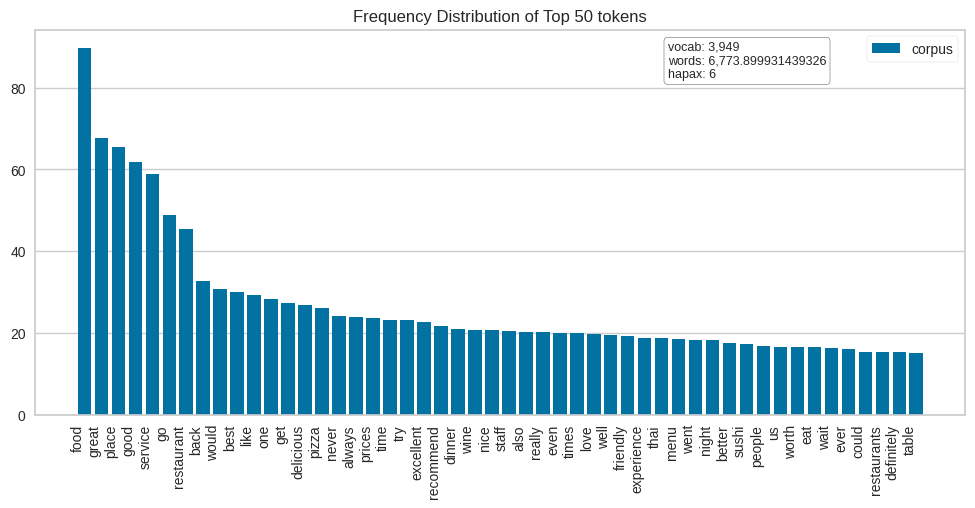

In [ ]:
plt.figure(figsize=(12,5))
visualizer = FreqDistVisualizer(features=features, orient='v', n=50)
visualizer.fit(vectorised_train_text)
plt.savefig('frequency_distribution.pdf', dpi=300)
visualizer.show()
plt.show()

## Saving processed data

In [ ]:
# Saving dataframes
joblib.dump(train_df, 'data/train_df.joblib')
joblib.dump(test_df, 'data/test_df.joblib')

In [ ]:
# Saving tfidf vectorizer to a file
joblib.dump(vectorizer, 'data/vectorizer.joblib')

# saving vectorized train and test text
joblib.dump(vectorised_train_text, 'data/vectorised_train_text.joblib')
joblib.dump(vectorised_test_text, 'data/vectorised_test_text.joblib')